This notebook runs ECMWF's aifs-single-v1 data-driven model, using ECMWF's [open data](https://www.ecmwf.int/en/forecasts/datasets/open-data) dataset and the [anemoi-inference](https://anemoi-inference.readthedocs.io/en/latest/apis/level1.html) package.

# 1. Install Required Packages and Imports

In [1]:
# Uncomment the lines below to install the required packages

# !pip install -q anemoi-inference[huggingface]==0.4.9 anemoi-models==0.3.1
# !pip install -q earthkit-regrid==0.4.0 ecmwf-opendata 
# !pip install -q flash_attn

In [2]:
import datetime
from collections import defaultdict

import numpy as np
import earthkit.data as ekd
import earthkit.regrid as ekr

from anemoi.inference.runners.simple import SimpleRunner
from anemoi.inference.outputs.printer import print_state

from ecmwf.opendata import Client as OpendataClient

# 2. Retrieve Initial Conditions from ECMWF Open Data




### List of parameters to retrieve form ECMWF open data

In [3]:
PARAM_SFC = ["10u", "10v", "2d", "2t", "msl", "skt", "sp", "tcw", "lsm", "z", "slor", "sdor"]
PARAM_SOIL =["vsw","sot"]
PARAM_PL = ["gh", "t", "u", "v", "w", "q"]
LEVELS = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]
SOIL_LEVELS = [1,2]

### Select a date

In [4]:
DATE = OpendataClient().latest()

In [5]:
print("Initial date is", DATE)

Initial date is 2025-02-19 18:00:00


### Get the data from the ECMWF Open Data API

In [6]:
def get_open_data(param, levelist=[]):
    fields = defaultdict(list)
    # Get the data for the current date and the previous date
    for date in [DATE - datetime.timedelta(hours=6), DATE]:
        data = ekd.from_source("ecmwf-open-data", date=date, param=param, levelist=levelist)
        for f in data:
            # Open data is between -180 and 180, we need to shift it to 0-360
            assert f.to_numpy().ndim ==2
            values = np.roll(f.to_numpy(), -f.shape[1] // 2, axis=1)
            # Interpolate the data to from 0.25 to N320
            values = ekr.interpolate(values, {"grid": (0.25, 0.25)}, {"grid": "N320"})
            # Add the values to the list
            name = f"{f.metadata('param')}_{f.metadata('levelist')}" if levelist else f.metadata("param")
            fields[name].append(values)

    # Create a single matrix for each parameter
    for param, values in fields.items():
        fields[param] = np.stack(values)

    return fields

### Get Input Fields

In [7]:
fields = {}

#### Add the single levels fields

In [8]:
fields.update(get_open_data(param=PARAM_SFC))

In [9]:
soil=get_open_data(param=PARAM_SOIL,levelist=SOIL_LEVELS)

Soil parameters have been renamed since training this model, we need to rename to the original names

In [10]:
mapping = {'sot_1': 'stl1', 'sot_2': 'stl2',
           'vsw_1': 'swvl1','vsw_2': 'swvl2'}
for k,v in soil.items():
    fields[mapping[k]]=v

#### Add the pressure levels fields

In [11]:
fields.update(get_open_data(param=PARAM_PL, levelist=LEVELS))

#### Convert geopotential height into geopotential

In [12]:
# Transform GH to Z
for level in LEVELS:
    gh = fields.pop(f"gh_{level}")
    fields[f"z_{level}"] = gh * 9.80665

### Create Initial State

In [13]:
input_state = dict(date=DATE, fields=fields)

# 3. Load the Model and Run the Forecast

### Download the Model's Checkpoint from Hugging Face & create a Runner

In [14]:
checkpoint = {"huggingface":"ecmwf/aifs-single-1.0"}

In [26]:
checkpoint = 'aifs-single-mse-1.0.ckpt'

In [27]:
runner = SimpleRunner(checkpoint, device="cuda")

#### Run the forecast

In [28]:
for state in runner.run(input_state=input_state, lead_time=12):
    print_state(state)


😀 date=2025-02-20T00:00:00 latitudes=(542080,) longitudes=(542080,) fields=102

    q_50   shape=(542080,) min=2.02856e-06    max=3.33228e-06   
    t_1000 shape=(542080,) min=236.843        max=311.371       
    v_925  shape=(542080,) min=-35.4004       max=29.1926       
    z_850  shape=(542080,) min=8252.9         max=15781.5       
    swvl2  shape=(542080,) min=0              max=0.712698      
    tcc    shape=(542080,) min=0              max=1             


😀 date=2025-02-20T06:00:00 latitudes=(542080,) longitudes=(542080,) fields=102

    q_50   shape=(542080,) min=2.03198e-06    max=3.30658e-06   
    t_1000 shape=(542080,) min=239.906        max=314.488       
    v_925  shape=(542080,) min=-33.547        max=30.9091       
    z_850  shape=(542080,) min=8385.94        max=15803.2       
    swvl2  shape=(542080,) min=0              max=0.710439      
    tcc    shape=(542080,) min=0              max=1             



# 4. Inspect the generated forecast

#### Plot a field

In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.tri as tri

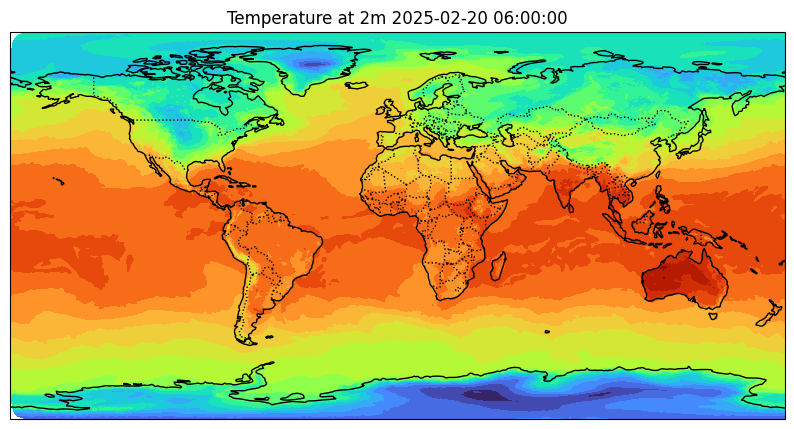

In [22]:
def fix(lons):
    # Shift the longitudes from 0-360 to -180-180
    return np.where(lons > 180, lons - 360, lons)

latitudes = state["latitudes"]
longitudes = state["longitudes"]
values = state["fields"]["2t"]

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

triangulation = tri.Triangulation(fix(longitudes), latitudes)
ax.tricontourf(triangulation, values, levels=20, transform=ccrs.PlateCarree(), cmap="turbo")
plt.title("Temperature at 2m {}".format(state["date"]))
plt.show()